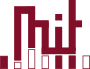 Department of Artificial Intelligence and Systems Engineering, ©2024, BME-MIT, Mihaly Vetro, Dr. Gabor Hullam  
# **VIMIAC16 - Artificial Intelligence**
## 2024 Fall Semester
## **LAB 7**

# **Ensemble learning**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## **1. Motivation**

When solving a supervised learning task using machine learning models, we usually utilize only *one predictive model*, which - depending on the nature of the problem (e.g. what do we want to predict) and practical aspects (e.g. how much data we have and how noisy it is) - can be a decision tree, logistic regression model, neural network, etc...

The question may arise, however, whether it is possible to improve the accuracy and reliability of the forecast by using the ensemble (e.g. average or other aggregated version) of the predictions of *multiple different models* instead of a single model. The process of building several different models to solve the same (or very similar) problem and then aggregating the predictions of these models to produce the final output is called **ensemble learning**.

The drawbacks of ensemble learning are easy to see, mainly because instead of a single model, we have to create a set of models, which requires more resources. In other aspects, however, the aggregate predictive performance of the set of models resulting from ensemble learning usually outperforms both the individual performance and the generalisation ability of the models that make it up.

> The latter fact is easy to see through a real-life example: as several empirical results have shown, some people's estimation ability is usually inaccurate due to individual bias. This becomes obvious if, for example, we ask someone to estimate by sight how many marbles are in a transparent jar, where most of the estimates will be significantly different from the actual number. However, if a sufficiently large number of people's estimates are averaged out, the result will be very close to the real number. The main reason for this is that the error of each estimate is (presumably) independent of the others, and this kind of error can be reduced by aggregating the results of several experiments.


## **2. Bagging and random forests**

One of the most fundamental ways to achieve ensemble learning is **Bagging**, which, in a slightly simplified way, consists of the following steps:

1. Consider a dataset consisting of $N$ records and $K$ variables.
2. Select a real subset of variables $k \in K$ (these are the columns of the data matrix of size $K*N$), and then perform **Bootstrapping** i.e. sample with replacement a set of records of size $N$ over the selected variables.
3. Fit a model to the resulting dataset.
4. Repeat steps **2** and **3** until a predefined number of models is obtained.
5. (**Aggregation**) The prediction of the resulting model set on the new sample is determined by majority voting in case of classification and by averaging in case of regression.

> Note that the dataset sampled in step **2** (**Bootstrapping**) contains only a subset of the variables and samples, and a sample may be included more than once due to replacement sampling. This step is particularly important to ensure that even for models with a deterministic (e.g. decision tree) or a low-variance (e.g. logistic regression) learning process, the procedure creates a heterogeneous model set, as each model learns on different subsets of the original dataset.

>Note: the original bagging algorithm always performed bootstrap sampling on the entire variable set. For random forests, however, it is preferable to have the set of variables also randomly sampled, as then the individual models are less correlated with each other. The general name for this technique is *Feature Bagging*, for random forests it is part of Bagging.

The schematic flowchart of the procedure in a simplified case creating 3 models is as follows:

<!-- ![bagging_algorithm](https://share.mit.bme.hu/index.php/s/RenmdjWN8LtXNfA/download/bagging_algorithm.png) -->

<img src="https://share.mit.bme.hu/index.php/s/RenmdjWN8LtXNfA/download/bagging_algorithm.png" alt="drawing" width="900"/>

A possible implementation of the Bagging algorithm used for classification is shown below.

**Examine the code, then run the code block to define the class!**


In [2]:
from sklearn.base import BaseEstimator, clone
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import mode

class BaggingClassifier:
    """
    An implementation of the Bagging algorithm for classification tasks
    for an arbitrary base estimator.

    Parameters
    ----------
    base_estimator : object
        A base estimator object implementing the `fit` and `predict` methods.
        If None, then the base estimator is a decision tree.
        Default: DecisionTreeClassifier()

    n_estimators : int
        The number of base estimators in the ensemble.
        Default: 100

    max_features : int or Nonep
        The number of features to consider when looking for the best split.
        If None, all features are considered.
        Default: None

    random_state : int or None
        The seed for the random number generator.
        If None, the random number generator is not seeded.
        Default: None
    """
    def __init__(self, base_estimator=DecisionTreeClassifier(), n_estimators=100, max_features=None, random_state=None):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.random_state = random_state
        self.estimators_ = []
        self.features_ = []

    @staticmethod
    def bootstrap_samples_(X, y, max_features=None, random_state=None):
        """
        Bootstrap samples from the input data.
        Samples are drawn with replacement.
        If max_features is specified, only a random subset of features is considered.

        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The input data.

        y : array-like, shape (n_samples,)
            The target values.

        max_features : int or None
            The number of features to consider when looking for the best split.
            If None, all features are considered.
            Default: None

        random_state : int or None
            The seed for the random number generator.
            If None, the random number generator is not seeded.
            Default: None
        """
        # Sample the dataset with replacement sampling
        X_sampled, y_sampled = resample(X, y, replace=True, random_state=random_state)
        # Subsample the features if the max number of features is specified
        if max_features is not None and max_features < X.shape[1]:
            if random_state is not None:
                np.random.seed(random_state)
            features = np.random.choice(X.shape[1], size=max_features, replace=False)
            X_sampled = X_sampled[:, features]
            # Return the feature indices along the subsampled data
            return X_sampled, y_sampled, features
        return X_sampled, y_sampled

    def fit(self, X, y):
        """
        Fit the model to the input data.

        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The input data.

        y : array-like, shape (n_samples,)
            The target values.
        """
        self.estimators_, self.features_ = [], []

        # Produce the specified number of estimators
        for i in range(self.n_estimators):
            # Initialize a local version of the random state, if specified.
            # Otherwise the bootstrapped samples would be the same for every model when the random state is specified.
            if self.random_state is not None:
                local_random_state = self.random_state * (i + 1) * self.n_estimators
            else:
                local_random_state = None

            if self.max_features is not None and self.max_features < X.shape[1]:
                # Sample the dataset with replacement and the specified number of features
                X_sampled, y_sampled, features = self.bootstrap_samples_(X, y, max_features=self.max_features,
                                                                         random_state=local_random_state)
                self.features_.append(features)
            else:
                # Sample the dataset with replacement if the number of features is not specified
                X_sampled, y_sampled = self.bootstrap_samples_(X, y, random_state=local_random_state)

            # Train a copy of the base estimator on the sampled data
            estimator = clone(self.base_estimator).fit(X_sampled, y_sampled)
            self.estimators_.append(estimator)

        return self

    def predict(self, X):
        """
        Predict the class labels for the input data.

        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The input data.
        """
        if self.max_features is not None and self.max_features < X.shape[1]:
            # Predict on the feature subset used for each estimator
            predictions = np.array([estimator.predict(X[:, features]) for estimator, features in zip(self.estimators_, self.features_)])
        else:
            # Predict on the entire feature set for each estimator
            predictions = np.array([estimator.predict(X) for estimator in self.estimators_])
        # Return the average predicted value for every input sample
        return mode(predictions, axis=0)[0]

Note that in the above class, the bootstrapping step is handled by a separate static function (`bootstrap_samples_`), and the aggregation is performed by the `predict` function by returning the mode of each model's prediction (`mode` function), which is equivalent to a majority vote.

To test the method, we then create an artificially generated dataset and split it into a training and test set using the code block below:

In [3]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# Create a dummy classification problem
X, y = make_classification(n_samples=1000, n_features=20,
                           n_informative=16, n_redundant=0,
                           flip_y=0.01, n_clusters_per_class=2,
                           hypercube=True, class_sep=1.,
                           random_state=42)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

The resulting dataset consists of randomly generated samples that form a given number of normally distributed clusters in the n-dimensional space for each class. For more information, see the documentation of the [`make_classification`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) function of the `sklearn` package.

With the above settings, a dataset consisting of a total of 1000 samples and 20 continuous variables is produced, which is divided into a training subset of 800 samples and a test subset of 200 samples. Their shape can be checked as follows:

In [4]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 20), (200, 20), (800,), (200,))

Next, define the following function, which performs the training of a predefined predictor on the generated dataset and then returns the accuracy of the trained model on the test set:

In [6]:
from sklearn.metrics import accuracy_score

def evaluate_classifier(classifier, runs=10):
    accuracies_local = []
    for _ in range(runs):
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies_local.append(accuracy)
    return np.mean(accuracies_local)

Since the learning process is non-deterministic (due to bootstrapping), the evaluation function above repeats the process several times and returns the average of the accuracies, so the resulting uncertainty of the accuracy value is lower.

Finally, we initialize the bagging classifier as below and observe how it performs in terms of accuracy on the artificial dataset:

In [7]:
from sklearn.tree import DecisionTreeClassifier

# Create a BaggingClassifier with Decision Trees as base estimators
bagging_model = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                                  n_estimators=20,
                                  max_features=int(np.sqrt(X.shape[1])))

accuracy = evaluate_classifier(bagging_model, runs=10)
print(f"Bagging Classifier Accuracy (Decision Tree): {accuracy:.3f}")

Bagging Classifier Accuracy (Decision Tree): 0.775


In the above example, a decision tree with a limited maximum depth (`base_estimator=DecisionTreeClassifier(max_depth=3)`) was given as the base model, from which 20 instances (`n_estimators=20`) were created to form a model ensemble. In addition, we specified that the bootstrapped samples for each model should contain a number of variables equal to the square root of the size of the total variable set (rounded to integer: `max_features=int(np.sqrt(X.shape[1]))`). The choice of the base model here is not accidental, as the widely known [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) algorithm is also based on the bagging method with a decision tree base model. However, it is important that the parameters of the bagging algorithm (including the base model) can be chosen arbitrarily.

**In the code block below, define and evaluate a bagging classifier similar to the one above, with different parameters!**

1. **Note the effect of the depth of the decision tree and the number of models on accuracy!**
2. **Try a different classifier as a base model!**

> Tip: for the base model, you should choose one of the following classifiers defined in the `sklearn` package:
1. [Support-Vector Machine](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) (RBF kernel is recommended)
2. [Naive Bayes](https://scikit-learn.org/dev//modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB)
3. [K-Nearest Neighbors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
4. [Gaussian Process](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessClassifier.html#sklearn.gaussian_process.GaussianProcessClassifier)

In [13]:
################################################################################
# TODO: create and evaluate a BaggingClassifier with different parameters!
# bagging_model = ...
################################################################################
from sklearn.neighbors import KNeighborsClassifier
p
bagging_model = BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=8),
                                   n_estimators=50,
                                   max_features=int(np.sqrt(X.shape[1])))

accuracy = evaluate_classifier(bagging_model, runs=10)
print(f"Bagging Classifier Accuracy (Decision Tree): {accuracy:.3f}")

Bagging Classifier Accuracy (Decision Tree): 0.810


In [ ]:
################################################################################
# TODO: create and evaluate a BaggingClassifier with a different baseline model!
# bagging_model = ...
################################################################################

accuracy = evaluate_classifier(bagging_model, runs=10)
print(f"Bagging Classifier Accuracy (other baseline): {accuracy:.3f}")

## **3. Boosting**

One of the noticeable characteristics of the Bagging algorithm is that each model was trained in a completely independent way based on a randomly selected sample. The advantage of this approach is of course that the creation of each model can be done in parallel, but a major disadvantage is that a relatively large number of models are required to achieve an aggregate prediction accuracy significantly better than that of the individual models.

The latter problem is addressed by the **Boosting** family of algorithms. These methods sequentially add new models to the ensemble of models in such a way that each added model "learns" in some way from the weaknesses of the existing models.

One of the earliest Boosting algorithms is Adaptive Boosting (**AdaBoost** for short), which means that for each model to be trained, more weight is given to the training examples for which the previous models gave incorrect predictions, so that the newly created model will perform better on those examples.

The AdaBoost method consists of the following steps:
1. As a starting step, define a uniform weight value for each record in the dataset.
2. Train a model with the current weights.
3. Increase the weights of the samples for which the most recent model gave an incorrect prediction, and then normalize the adjusted weight vector.
4. Repeat step 2 until a pre-specified number of models is obtained.
5. The prediction of the ensemble of models on new samples is obtained as the weighted aggregate of the output of each model. In the aggregation process, the weight of each model's output increases with its better predictive performance on the training set.

> The AdaBoost algorithm (and Boosting methods in general) iteratively corrects errors in the existing model ensemble at each step, speeding up the convergence of the procedure. For this reason, typically fewer models are needed to achieve similarly good predictive performance when using this family of methods compared to the Bagging algorithm.

The schematic flowchart of the AdaBoost algorithm for 3 models is as follows:
<!-- ![adaboost_algorithm_simplified](https://share.mit.bme.hu/index.php/s/bW9FgHTr3xJpQdm/download/boosting_algorithm_simplified.png) -->

<img src="https://share.mit.bme.hu/index.php/s/bW9FgHTr3xJpQdm/download/boosting_algorithm_simplified.png" alt="drawing" width="700"/>

As can be seen in the figure above, the learning of each model depends on the error of the previous model, so the learning of each model cannot be performed in parallel, only sequentially.

There are several implementations of the AdaBoost algorithm, we will use the one included in the `sklearn` package. In practical terms, the instantiation and use of the AdaBoost classifier is similar to the bagging method implemented above:

In [16]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

boosted_model_dt = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3),
                                      n_estimators=20,
                                      algorithm="SAMME")

accuracy = evaluate_classifier(boosted_model_dt, runs=10)
print(f"Boosted Classifier Accuracy (Decision Tree): {accuracy:.3f}")

Boosted Classifier Accuracy (Decision Tree): 0.839


It is also worth comparing how AdaBoost performs against the Bagging algorithm for model ensembles of different sizes. To do this, run the training and evaluation for different model sizes and plot the results using the code block below:

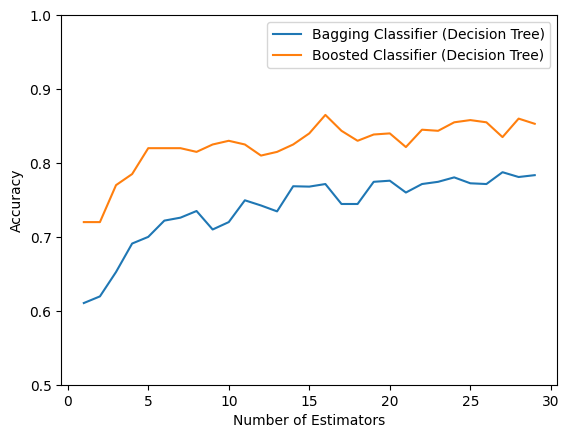

In [17]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

accuracy_values_bagging = []
accuracy_values_boosting = []

for n_estimators in range(1, 30, 1):
    bagging_model_dt = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                                         n_estimators=n_estimators,
                                         max_features=int(np.sqrt(X.shape[1])))
    accuracy_values_bagging.append(evaluate_classifier(bagging_model_dt, runs=10))

    boosted_model_dt = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3),
                                          n_estimators=n_estimators,
                                          algorithm="SAMME")
    accuracy_values_boosting.append(evaluate_classifier(boosted_model_dt, runs=10))

plt.plot(range(1, 30, 1), accuracy_values_bagging, label="Bagging Classifier (Decision Tree)")
plt.plot(range(1, 30, 1), accuracy_values_boosting, label="Boosted Classifier (Decision Tree)")
plt.xlabel("Number of Estimators")
plt.ylabel("Accuracy")
plt.ylim((0.5, 1.))
plt.legend()
plt.show();

***
**Which method do you think performed better with the same base model and ensemble size?**

Boosting

***

**Based on the results, to what extent does the predictive performance of the two methods increase with the number of models? Do you see any difference between the methods in this regard?**

In a wary similar way nearly linear after a while

***

Finally, it is worth mentioning that there are several boosting algorithms that are more modern than AdaBoost, of which gradient-based methods are perhaps the best known. Examples include the [`GradientBoostingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) implemented in `sklearn` and the [Extreme Gradient Boosting](https://xgboost.readthedocs.io/en/stable/), which is available as a separate package.

## **4. Stacking**

So far, we have assumed that all members of the model ensemble are from the same model family (e.g. decision tree, SVM, etc...). However, this is not necessarily the case, since a model ensemble can consist of any type of classifiers (or regressors) as long as they offer a solution to the same classification (or regression) problem. The general case where a model ensemble is composed of estimators from different model families is called **Stacking**.

The implementation is simpler than before: using `sklearn`, we initialize some individual classifiers, and then a model ensemble ([`VotingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html)) from them. The resulting estimator is trained and evaluated as a single model.

This can be done by running the following code block on the previously generated artificial dataset:

In [18]:
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier

# Create a VotingClassifier with multiple base estimators
stacking_model = VotingClassifier(estimators=[
    ('decision_tree', DecisionTreeClassifier(max_depth=3)),
    ('svm', SVC(kernel='rbf')),
    ('naive_bayes', GaussianNB()),
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('gaussian_process', GaussianProcessClassifier())
], voting='hard')

accuracy = evaluate_classifier(stacking_model, runs=10)

print(f"Stacking Classifier Accuracy: {accuracy:.3f}")

Stacking Classifier Accuracy: 0.955


During the implementation, a cluster of 5 models was created, each of which solves the classification problem in a drastically different way. This is described in more detail in the documentation of the classes implementing each model:

1. [Decision Tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
2. [Support-Vector Machine](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
3. [Naive Bayes](https://scikit-learn.org/dev//modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB)
4. [K-Nearest Neighbors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
5. [Gaussian Process](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessClassifier.html#sklearn.gaussian_process.GaussianProcessClassifier)

> It is worth noting that the classifier created using the Stacking procedure, which includes 5 different models, has significantly better performance than the previous ensembles of models with instances of a single model type. This implies that when solving the classification problem defined by the artificially generated dataset, there is a significant advantage in the diversity of models, or in other words: in this case, the predictions of models representing different approaches complement each other well. A third (and perhaps most common) formulation of this phenomenon is that individual models in a model ensemble typically make errors on different inputs, so that the simple majority decision they make is more reliable than the prediction of each model. It is important to note, however, that this is not necessarily true for all classification (or indeed regression) problems, so individual testing of different approaches is still important. For example, it may be that a number of models perform particularly poorly on the dataset, so that the performance of the ensemble of models may be worse than the performance of some individual models.

## **5. Real dataset**

In the following section, we will test the methods we have learned so far on a real dataset in a format similar to the artificially generated dataset we have used so far.

To do this, we first reset the Colab environment and then load the dataset to be used:

In [34]:
%reset -f
import numpy as np
import pandas as pd

spambase_df = pd.read_csv("https://share.mit.bme.hu/index.php/s/wgc46gCHRb7bPdF/download/spambase.csv")

spambase_df

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,Class
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.0,0.778,0.000,0.00,3.756,61,278,1
1,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.010,0.143,0.0,0.276,0.184,0.01,9.821,485,2259,1
2,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.000,0.137,0.0,0.137,0.000,0.00,3.537,40,191,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.000,0.135,0.0,0.135,0.000,0.00,3.537,40,191,1
4,0.00,0.00,0.00,0.0,1.85,0.00,0.00,1.85,0.00,0.00,...,0.000,0.223,0.0,0.000,0.000,0.00,3.000,15,54,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3676,0.00,0.00,1.19,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.0,0.000,0.000,0.00,1.000,1,24,0
3677,0.31,0.00,0.62,0.0,0.00,0.31,0.00,0.00,0.00,0.00,...,0.000,0.232,0.0,0.000,0.000,0.00,1.142,3,88,0
3678,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.0,0.353,0.000,0.00,1.555,4,14,0
3679,0.30,0.00,0.30,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.102,0.718,0.0,0.000,0.000,0.00,1.404,6,118,0


The above database contains a total of 57 continuous-valued variables and one binary target variable. The input variables are descriptive statistics extracted from emails, giving the relative frequency of occurrence of each word and character (in percentage terms, variables starting with `word_freq_*` and `char_freq_*`), the average length of all uppercase character sequences, the length of the longest such sequence, and the total number of uppercase characters. The target variable is `Class`, shown in the last column of the dataset, which indicates whether the original email is considered spam (`Class=1`) or not (`Class=0`).

Then, in preparation for training, let us split the dataset into training and test subsets:

In [35]:
from sklearn.model_selection import train_test_split

X = spambase_df.drop("Class", axis=1).values
y = spambase_df["Class"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

## **6. Task submission**

The task is to create a spam classifier using the model ensembles described above and the `spambase` dataset.

**Do this by modifying the skeleton of the `spam_predictor.py` file shown below!**

Modify the `predict` function in the skeleton to create a model ensemble of any type, train it on the training data (`X_train` and `y_train`) given as parameters, and return with predictions on the test set (`X_test`) given as a parameter.

> Hint: The `sklearn` library is installed on the Moodle evaluation server, so you should use the [model ensemble methods](https://scikit-learn.org/stable/api/sklearn.ensemble.html) and [classifiers](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html) provided there.

In [43]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

def predict(X_train, y_train, X_test):

    ensemble_model = AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=3),
        n_estimators=50,
        learning_rate=1.0,
        random_state=42,
        algorithm="SAMME"
    )


    ensemble_model.fit(X_train, y_train)
    return ensemble_model.predict(X_test)

We then check the accuracy of the `predict` function defined above on the test set:

In [42]:
from sklearn.metrics import accuracy_score

y_pred = predict(X_train, y_train, X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Ensemble Classifier Accuracy: {accuracy:.3f}")

Ensemble Classifier Accuracy: 0.948


The Moodle assignment for the lab is considered complete if a separate test set in the `spambase` database achieves at least `93%` accuracy. The test set used in the Moodle system **is not identical to the test set seen here**, but contains the same variables.

> **Important:** When submitting the assignment, please make sure that the file name is `spam_predictor.py` and that the `predict` function is defined in the same way as shown above.

Submission:

https://edu.vik.bme.hu/mod/quiz/view.php?id=152403